<a href="https://colab.research.google.com/github/jonghhhh/lecture_colabs/blob/main/%EB%AC%B8%EC%84%9C_%EC%9C%A0%EC%82%AC%EB%8F%84_%EA%B2%80%EC%83%89%EA%B3%BC_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81_SBERT_FAISS_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문서 유사도 검색과 클러스터링: BERT, FAISS ,K-means 활용

### SBERT:
- BERT를 기본 모델로 사용하지만, 문장 임베딩 생성을 위해 최적화
- Mean Pooling 벡터 사용: 분류기 개발용 BERT 활용에서는 CLS(Classification) 토큰 벡터 사용
- 유사성 측정에 적합: 코사인 유사도(cosine similarity)나 유클리드 거리(Euclidean distance) 등을 사용

### FAISS(Facebook AI Similarity Search)
- 대규모 벡터 검색 및 클러스터링을 위한 라이브러리. 주로 고차원 벡터의 빠른 유사성 검색을 수행

### K-means 클러스터링
- 비지도 학습 알고리즘으로, 데이터를 여러 그룹(클러스터)으로 나누는 데 사용

In [ ]:
!pip install faiss-gpu
!pip install transformers
!pip install sentence-transformers

## 검색1: 전체 데이터에서 거리 가까운 문장 사례 찾기(유클리드거리, L2)

In [ ]:
import numpy as np
import faiss
import pickle
from sentence_transformers import SentenceTransformer
import pandas as pd

# SentenceTransformer 모델 로드
model = SentenceTransformer('bongsoo/kpf-sbert-v1')   # 768차원

# 검색 대상 데이터 로드
df = pd.read_excel('--data.xlsx')
df.info()

# 문장 임베딩
df1 = df[df['text'].apply(lambda x: isinstance(x, str))] # text: 분석 대상 변수
embeddings = model.encode(df1['text'].tolist())
embeddings.shape

# (필요하면) embeddings 저장
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

# (필요하면) embeddings 불러오기
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

# FAISS 인덱스 생성
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# 찾고자 하는 문장
query_sentence = "-----------------------------"

# 찾고자 하는 문장의 임베딩
query_embedding = model.encode([query_sentence])

# 유사도 검색
k = 5  # 상위 5개 문장
distances, indices = index.search(query_embedding, k)

# 유사한 문장을 데이터프레임으로 출력
df_result=df1[df1['id'].isin(indices[0].tolist())]
df_result['거리']=distances[0].tolist()
df_result = df_result.sort_values(by='거리')
print(df_result)


## 검색2: 전체 데이터에서 거리 가까운 문장 사례 찾기(코사인유사도)



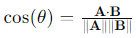

코사인 유사도의 값은 -1에서 1 사이에 위치(1에 가까울수록 유사하고, -1에 가까울수록 다름)

In [ ]:
import numpy as np
import faiss
import pickle
from sentence_transformers import SentenceTransformer
import pandas as pd

# SentenceTransformer 모델 로드
model = SentenceTransformer('bongsoo/kpf-sbert-v1')   # 768차원

# 검색 대상 데이터 로드
df = pd.read_excel('--data.xlsx')
df.info()

# 문장 임베딩
df1 = df[df['text'].apply(lambda x: isinstance(x, str))] # text: 분석 대상 변수
embeddings = model.encode(df1['text'].tolist())

# 코사인 유사도 계산을 위한 임베딩 정규화(normalization): L2 정규화된 벡터의 코사인 유사도 = 두 정규화된 벡터 간의 내적
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings_norm.shape

# (필요하면) embeddings 저장
with open('embeddingsNorm.pkl', 'wb') as f:
    pickle.dump(embeddings_norm, f)

# (필요하면) embeddings 불러오기
with open('embeddingsNorm.pkl', 'rb') as f:
    embeddings_norm = pickle.load(f)

# FAISS index 생성: 내적(inner product)으로 검색 목적
d = embeddings_norm.shape[1] # 임베딩의 차원 수를 저장:  embeddings_norm은 (문장 수, 차원 수) 형태의 2차원 배열이므로, shape[1]은 임베딩의 차원 수를 나타냄
index = faiss.IndexFlatIP(d) # 내적(IP, Inner Product) 검색을 위한 FAISS 인덱스 생성. IndexFlatIP는 내적 기반의 유사도 검색을 위한 인덱스를 의미
index.add(embeddings_norm) # 정규화된 임베딩을 인덱스에 추가. 검색을 위해 미리 계산된 모든 문장 임베딩을 인덱스에 추가하여 검색이 가능하도록 함


# 찾고자 하는 문장
query_sentence = "-----------------------------------------"

# 찾고자 하는 문장의 임베딩
query_embedding = model.encode([query_sentence])

# Normalize the query embedding
query_embedding_norm = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

# 유사도 검색
k = 5  # 상위 5개 문장
distances, indices = index.search(query_embedding_norm, k)
cosine_similarities = distances[0]

# 유사한 문장을 데이터프레임으로 출력
df_result = df1.iloc[indices[0]].copy()
df_result['유사도'] = cosine_similarities
# Sort the results by similarity in descending order
df_result = df_result.sort_values(by='유사도', ascending=False)
df_result

## 군집분석(clustering)

### K-means에서 적절한 군집 개수 찾기(Elbow Method) 함수화
- 군집(클러스터) 수에 따른 WCSS(Within-Cluster Sum of Squares) 계산해, WCSS가 급격히 감소했다 완화하는 지점 찾기

In [ ]:
!pip install faiss-gpu
!pip install matplotlib

import faiss
import matplotlib.pyplot as plt

def calculate_wcss(document_vectors):
    wcss = []
    for i in range(1, 11):
        kmeans = faiss.Kmeans(d=document_vectors.shape[1], k=i, niter=20, gpu=True)
        kmeans.train(document_vectors)
        wcss.append(kmeans.obj[-1])
    return wcss

### 군집분석: 유클리드 거리와 코사인 유사도 사용

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# 분석 대상 DataFrame 로드
df = pd.read_excel('--data.xlsx')
df1 = df[df['text'].apply(lambda x: isinstance(x, str))] # text: 분석 대상 변수
documents=list(df1['text'])

# SentenceTransformer 모델 로드
model = SentenceTransformer('bongsoo/kpf-sbert-v1')

# 문장 임베딩(벡터화)
document_vectors = model.encode(documents, convert_to_tensor=False)
# 문서 벡터를 numpy 배열로 변환
document_vectors = np.array(document_vectors)

# GPU 사용을 위한 설정
res = faiss.StandardGpuResources()  # GPU 리소스 할당
index_flat = faiss.IndexFlatL2(document_vectors.shape[1])  # L2 거리 기반 인덱스
gpu_index = faiss.index_cpu_to_gpu(res, 0, index_flat)  # GPU로 인덱스 이동

# 클러스터 개수 도출: WCSS 계산
wcss = calculate_wcss(document_vectors)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Faiss를 이용한 클러스터링
num_clusters = 4  # 위에서 찾은 Optimal k(최적의 클러스터 수) 입력
kmeans = faiss.Kmeans(d=document_vectors.shape[1], k=num_clusters, niter=20, gpu=True)  # GPU를 사용한 K-means
kmeans.train(document_vectors)

# 클러스터 할당과 분포 확인
_, cluster_assignments = kmeans.index.search(document_vectors, 1)  # 각 벡터에 클러스터 할당
cluster_list=cluster_assignments.flatten().tolist()
Counter(cluster_list)


# 각 문서의 클러스터 중심점과의 유클리드 거리 및 코사인 유사도 계산
num_documents = len(documents)  # 문서의 개수
centroids = kmeans.centroids  # 클러스터 중심
distances = np.zeros(num_documents)  # 문서와 클러스터 중심 간의 거리를 저장할 배열
cosine_similarities = np.zeros(num_documents)  # 문서와 클러스터 중심 간의 코사인 유사도를 저장할 배열
for i in range(num_documents):
    cluster_idx = cluster_assignments[i]  # 문서가 속한 클러스터의 인덱스
    centroid = centroids[cluster_idx]  # 해당 클러스터의 중심점
    vector = document_vectors[i]  # 문서의 벡터 표현
    # 문서 벡터와 클러스터 중심점 간의 유클리드 거리(L2 거리) 계산
    distances[i] = np.linalg.norm(vector - centroid)
    # 코사인 유사도를 계산하기 위해 벡터와 중심점을 2차원 형태로 변환
    vector_2d = vector.reshape(1, -1)
    centroid_2d = centroid.reshape(1, -1)
    # 문서 벡터와 클러스터 중심점 간의 코사인 유사도 계산
    cosine_similarities[i] = cosine_similarity(vector_2d, centroid_2d)[0][0]


# 분석 결과 담을 데이터프레임 생성
df_clustered = pd.DataFrame({
    'Document': documents,
    'Cluster': cluster_list,
    'Distance': distances,
    'Cosine Similarity': cosine_similarities
})

df_clustered=pd.merge(df1, df_clustered, left_on='사례', right_on='Document', how='left')
df_clustered.to_excel('cluster_added.xlsx')

### 중심점(centroids) 저장과 군집(cluster) 대표(가까운) 문서 보여주기

In [ ]:
# centroids(kmeans.centroids) 저장: pickle 양식
import pickle

kmeans.centroids.shape #  확인

with open("centroids.pkl", "wb") as pickle_file:
    pickle.dump(kmeans.centroids, pickle_file)
with open("centroids.pkl", "rb") as pickle_file:  # 나중에 로드할 때
    loaded_centroids = pickle.load(pickle_file)


# 각 클러스터의 대표 문서 10개 선택 (클러스터 중심에 가장 가까운-유사한 문서)
cluster_representatives = []

for i in range(num_clusters):
    cluster_docs = df_clustered[df_clustered['Cluster'] == i]
    closest_docs = cluster_docs.nsmallest(10, 'Distance')  # 유클리드 거리 기준 상위 10개 문서을 찾을 때는 이 줄 수행
    #closest_docs = cluster_docs.nlargest(10, 'Cosine Similarity')  # 코사인 유사도 기준 상위 10개 문서를 찾을 때는 이 줄 수행
    for _, row in closest_docs.iterrows():
        cluster_representatives.append({
            'Cluster': i,
            'Document': row['Document'],
            'Distance': row['Distance'],
            'Cosine Similarity': row['Cosine Similarity']
        })

df_representatives = pd.DataFrame(cluster_representatives)

### 시각화: t-SNE(t-distributed Stochastic Neighbor Embedding) 활용

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# TSNE 변환
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(document_vectors)

# tsne 결과를 데이터프레임에 추가
df_clustered['TSNE-2D-one'] = tsne_results[:, 0]
df_clustered['TSNE-2D-two'] = tsne_results[:, 1]

# 시각화
plt.figure(figsize=(16, 10))
palette = sns.color_palette("hsv", num_clusters)

# 군집 번호 및 중심점 표시를 위한 데이터프레임 생성
centroid_tsne = tsne.fit_transform(centroids)

# TSNE 시각화
sns.scatterplot(
    x='TSNE-2D-one', y='TSNE-2D-two',
    hue='Cluster',
    palette=palette,
    data=df_clustered,
    legend="full",
    alpha=0.7
)

# 중심점 표시
for i, (x, y) in enumerate(centroid_tsne):
    plt.scatter(x, y, marker='X', s=200, c='black')
    plt.text(x, y, str(i), fontsize=12, fontweight='bold', color='black', ha='center', va='center')

plt.title('TSNE plot of clusters with centroids')
plt.xlabel('TSNE-2D-one')
plt.ylabel('TSNE-2D-two')
plt.legend(loc='best', title='Cluster')
plt.show()